In [1]:
import torch
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import sys
sys.path.insert(0, '../')
sys.path.insert(0, '../GGH')

from GGH.data_ops import DataOperator
from GGH.selection_algorithms import AlgoModulators
from GGH.models import initialize_model, Autoencoder
from GGH.train_val_loop import TrainValidationManager
from GGH.inspector import Inspector, plot_histogram, visualize_train_val_error, selection_histograms, create_heatmap, cluster_and_visualize, \
                            get_gradarrays_n_labels, prep_tsne_min_max_ranges, sep_grads_by_labels, clean_final_analysis
from GGH.imputation_methods import Imputer
import warnings
warnings.filterwarnings('ignore')

def full_experiment(use_info, DO, INSPECT, batch_size, hidden_size, output_size, num_epochs, rand_state, results_path, dropout = 0.05, lr = 0.004, nu = 0.1,
                    normalize_grads_contx = False, use_context = True, final_analysis = False):
       
    AM = AlgoModulators(DO, lr = lr, nu = nu, normalize_grads_contx = False, use_context = True, freqperc_cutoff = 0.25)
    dataloader = DO.prep_dataloader(use_info, batch_size)

    model = initialize_model(DO, dataloader, hidden_size, rand_state, dropout = dropout) 

    TVM = TrainValidationManager(use_info, num_epochs, dataloader, batch_size, rand_state, results_path, final_analysis = final_analysis)
    TVM.train_model(DO, AM, model, final_analysis = final_analysis)

    INSPECT.save_train_val_logs(DO, AM, TVM, model, final_analysis = final_analysis)
    
    return DO, TVM, model

def multi_experiments(total_runs, use_info, num_epochs, data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc,
                      INSPECT, batch_size, hidden_size, output_size, results_path, hyperparameters, final_analysis = True):
    
    clean_final_analysis(results_path, use_info)
    progress_bar = tqdm(total=total_runs)
    for r_state in range(2000): #
        set_to_deterministic(r_state)
        DO = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, r_state, device = "cpu")
        if not DO.lack_partial_coverage:
            full_experiment(use_info, DO, INSPECT, batch_size, hidden_size, output_size, num_epochs, r_state, results_path,
                            hyperparameters["dropout"]["value"], hyperparameters["lr"]["value"], hyperparameters["nu"]["value"],
                            hyperparameters["normalize_grads_contx"]["value"], hyperparameters["use_context"]["value"], final_analysis)
            progress_bar.update(1)
        if progress_bar.n == total_runs:
            break       
    progress_bar.close()
    
def set_to_deterministic(rand_state):
    
    import random
    import numpy as np
    import torch
    
    random.seed(rand_state)
    np.random.seed(rand_state)
    torch.manual_seed(rand_state)

    torch.set_num_threads(1)
    #torch.set_num_interop_threads(1)
    torch.use_deterministic_algorithms(True)

In [71]:
df = pd.read_csv('../data/donated_blood/donated_blood_subsampled_balance.csv')

In [72]:
len(df)

478

In [47]:
358

358.5

<AxesSubplot:>

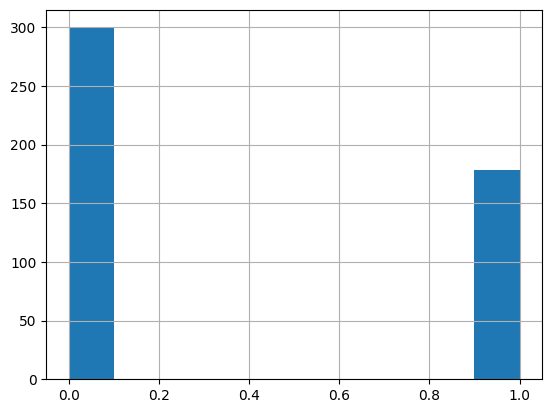

In [9]:
df.Donate_Blood.hist()

<AxesSubplot:>

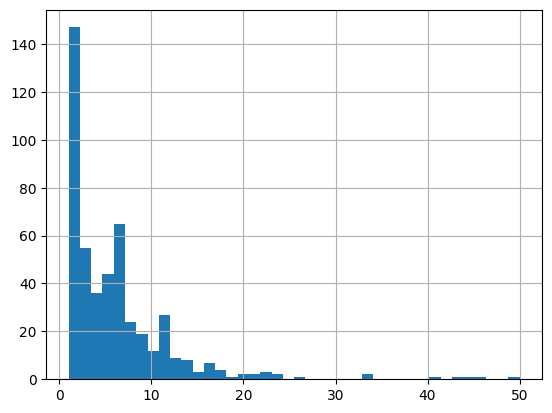

In [19]:
df["Frequency"].hist(bins = 40)

<AxesSubplot:>

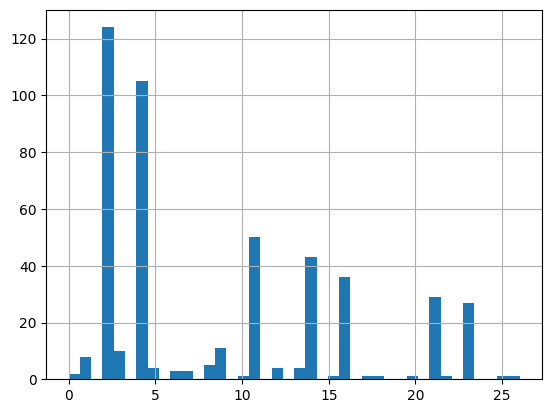

In [88]:
#[[2, 6, 19, 80]]

#[[2, 4, 10, 16, 21]]

df[df["Recency"]<30]["Recency"].hist(bins = 40)

In [63]:
len(df[(df["Recency"]>19) & (df["Recency"]<=80)])/len(df)

0.1297071129707113

In [66]:
360*0.1297*0.2

9.3384

In [93]:
data_path = '../data/donated_blood/donated_blood_subsampled_balance.csv'

partial_perc = 0.2
inpt_vars = ['Time']
target_vars = ['Donate_Blood']
miss_vars = ['Recency']
hypothesis = [[2, 4, 10, 16, 21]]

r_state = 1
#rand_state = 1; parc is not complete

In [81]:
0.148649/0.027027

5.5000185000185

In [94]:
DO = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, r_state, device = "cpu")

In [95]:
DO.lack_partial_coverage

False

In [96]:
DO.df_train_hypothesis["correct_class_id"].value_counts()

0    490
1    425
3    350
2    230
4    225
Name: correct_class_id, dtype: int64

In [75]:
478*4*0.72

1376.6399999999999

In [74]:
720+352+300+4

1376

In [78]:
DO.df_train_hypothesis["correct_hypothesis"]

0       False
1        True
2       False
3       False
4       False
        ...  
1371    False
1372    False
1373    False
1374     True
1375    False
Name: correct_hypothesis, Length: 1376, dtype: bool

In [79]:
DO.df_train_hypothesis.head()

,Time,hyp_class_id,Recency,Donate_Blood,partial_full_info,correct_class_id,Recency_hypothesis,correct_hypothesis,global_id,sel_hyp_tracker,final_sel_hyp,loss,gradients
0,0.760417,0,0.148649,0,1,1,0.027027,False,0,[],[],[],[]
1,0.760417,1,0.148649,0,1,1,0.148649,True,1,[],[],[],[]
2,0.760417,2,0.148649,0,1,1,0.256757,False,2,[],[],[],[]
3,0.760417,3,0.148649,0,1,1,1.081081,False,3,[],[],[],[]
4,0.645833,0,0.189189,0,1,1,0.027027,False,4,[],[],[],[]


In [80]:
DO.hyp_class_thresh

[[0.08783783783783784, 0.2027027027027027, 0.668918918918919]]

In [ ]:
if not hyp_class_thresh:
    for l_i in range(len(DO.hypothesis)):
        hyp_c_l = []
        for i in range(len(DO.hypothesis[l_i])-1):
            hyp_c_l.append(np.mean([DO.hypothesis[l_i][i],DO.hypothesis[l_i][i+1]]))
        hyp_class_thresh.append(hyp_c_l)

In [118]:
#User requiered data and parameters
data_path = '../data/donated_blood/donated_blood_subsampled_balance.csv'
results_path = "../saved_results/Donated Blood"
inpt_vars = ['Time'] #'Recency', 
target_vars = ['Donate_Blood']
miss_vars  = ['Recency']  # ['Frequency']    # ['Recency']
hypothesis =  [[2, 4, 10, 16, 21]] # [[1, 4, 9, 50]] # [[2, 11, 19, 80]]

#Percentage of simulated data with full information
partial_perc = 0.1
rand_state = 0

#Model Train Parameters
hidden_size = 32

batch_size = 100*len(hypothesis[0])
output_size = len(target_vars)

#Call data, algorithm and model classes
INSPECT = Inspector(results_path, hidden_size)

In [136]:
DO.problem_type

'binary-class'

In [ ]:
#partial_perc = 0.1
#real epochs = 50
#loop 1
#inpt_vars = ['Time'] #Frequency
#target_vars = ['Donate_Blood']
#miss_vars = ['Recency']
#hypothesis = [[2, 4, 10, 16, 21]] #Recency

100%|██████████| 5/5 [00:15<00:00,  3.16s/it]


0.631578947368421
0.6379310344827587
0.669642857142857
0.7374517374517374


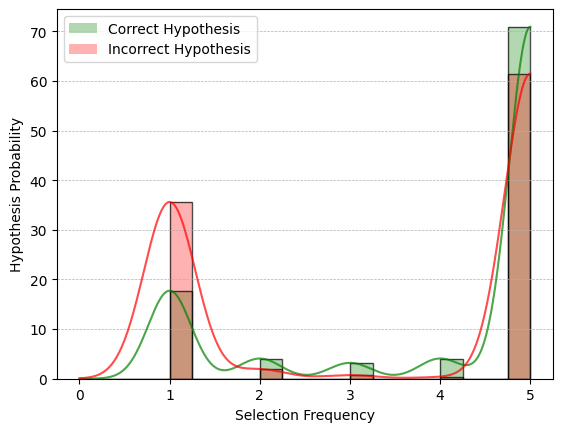

In [125]:
#partial at 10%
use_info = "use hypothesis"
num_epochs = 5
rand_state = 2
DO = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, rand_state, device = "cpu")
DO, TVM, model = full_experiment(use_info, DO, INSPECT, batch_size, hidden_size, output_size, num_epochs, rand_state, 
                                 results_path, dropout = 0.05, nu = 0.1, normalize_grads_contx = False, use_context = True, final_analysis = False)

print(INSPECT.calculate_val_acc(DO, TVM, model, data = "validation"))
print(INSPECT.calculate_val_acc(DO, TVM, model, data = "test"))

print(INSPECT.calculate_val_auc(DO, TVM, model, data = "validation"))
print(INSPECT.calculate_val_auc(DO, TVM, model, data = "test"))

selection_histograms(DO, TVM, num_epochs, rand_state, partial_perc)

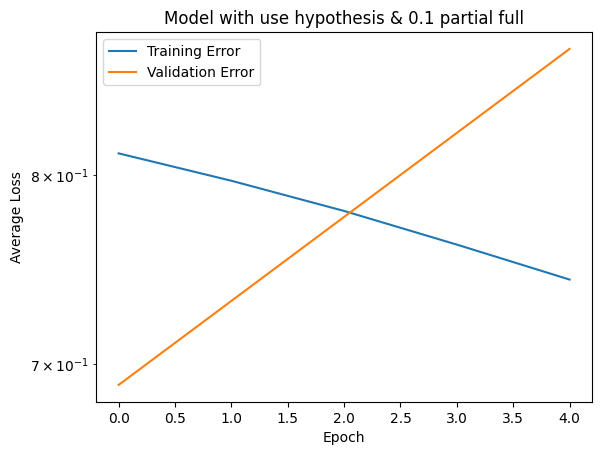

In [124]:
visualize_train_val_error(DO, TVM)


100%|██████████| 5/5 [00:17<00:00,  3.51s/it]


0.5394736842105263
0.6206896551724138
0.6111498257839721
0.5820707070707071


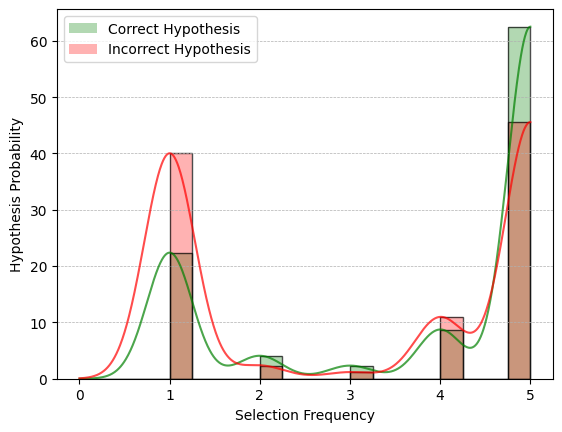

In [134]:
#partial at 10%
use_info = "use hypothesis"
num_epochs = 5
rand_state = 1
DO = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, rand_state, device = "cpu")
DO, TVM, model = full_experiment(use_info, DO, INSPECT, batch_size, hidden_size, output_size, num_epochs, rand_state, 
                                 results_path, dropout = 0.05, nu = 0.1, normalize_grads_contx = False, use_context = True, final_analysis = False)

print(INSPECT.calculate_val_acc(DO, TVM, model, data = "validation"))
print(INSPECT.calculate_val_acc(DO, TVM, model, data = "test"))

print(INSPECT.calculate_val_auc(DO, TVM, model, data = "validation"))
print(INSPECT.calculate_val_auc(DO, TVM, model, data = "test"))

selection_histograms(DO, TVM, num_epochs, rand_state, partial_perc)

In [135]:
from GGH.models import load_model

# After training
best_model = load_model(DO, TVM.weights_save_path, batch_size)
print(INSPECT.calculate_val_acc(DO, TVM, best_model, data="test"))
print(INSPECT.calculate_val_auc(DO, TVM, best_model, data="test"))

0.6206896551724138
0.5505050505050504


100%|██████████| 50/50 [02:40<00:00,  3.22s/it]
findfont: Font family ['Cambria'] not found. Falling back to DejaVu Sans.


0.5921052631578947
0.5862068965517241
0.6942652329749103
0.7285539215686274


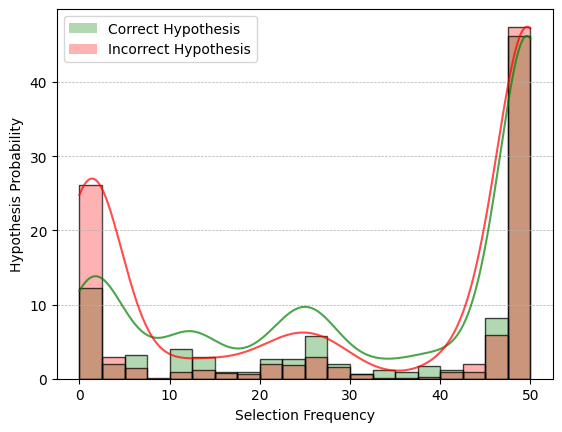

In [119]:
#partial at 10%
use_info = "use hypothesis"
num_epochs = 50
DO = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, rand_state, device = "cpu")
DO, TVM, model = full_experiment(use_info, DO, INSPECT, batch_size, hidden_size, output_size, num_epochs, rand_state, 
                                 results_path, dropout = 0.05, nu = 0.1, normalize_grads_contx = False, use_context = True, final_analysis = False)

print(INSPECT.calculate_val_acc(DO, TVM, model, data = "validation"))
print(INSPECT.calculate_val_acc(DO, TVM, model, data = "test"))

print(INSPECT.calculate_val_auc(DO, TVM, model, data = "validation"))
print(INSPECT.calculate_val_auc(DO, TVM, model, data = "test"))

selection_histograms(DO, TVM, num_epochs, rand_state, partial_perc)

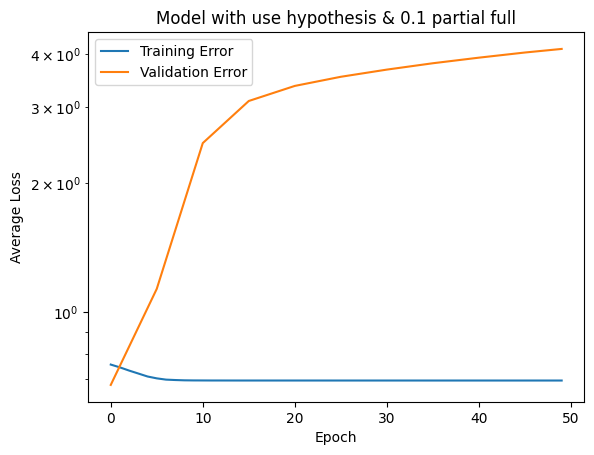

In [120]:
visualize_train_val_error(DO, TVM)

100%|██████████| 40/40 [00:48<00:00,  1.21s/it]
findfont: Font family ['Cambria'] not found. Falling back to DejaVu Sans.


0.5921052631578947
0.7068965517241379
0.49426523297491043
0.6169296987087518


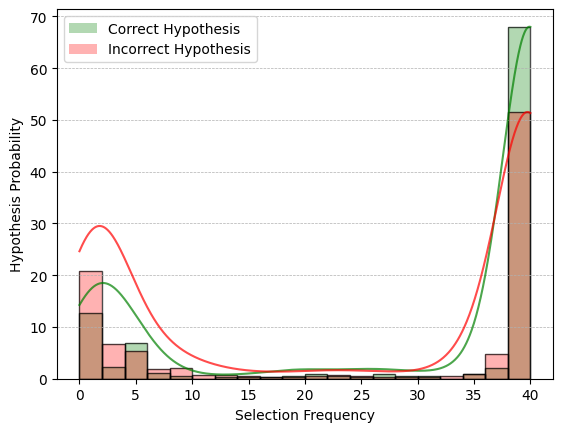

In [12]:
#partial at 5%
use_info = "use hypothesis"
num_epochs = 40
DO = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, rand_state, device = "cpu")
DO, TVM, model = full_experiment(use_info, DO, INSPECT, batch_size, hidden_size, output_size, num_epochs, rand_state, 
                                 results_path, dropout = 0.05, nu = 0.1, normalize_grads_contx = False, use_context = True, final_analysis = False)

print(INSPECT.calculate_val_acc(DO, TVM, model, data = "validation"))
print(INSPECT.calculate_val_acc(DO, TVM, model, data = "test"))

print(INSPECT.calculate_val_auc(DO, TVM, model, data = "validation"))
print(INSPECT.calculate_val_auc(DO, TVM, model, data = "test"))

selection_histograms(DO, TVM, num_epochs, rand_state, partial_perc)

100%|██████████| 100/100 [03:03<00:00,  1.84s/it]


0.5921052631578947
0.7068965517241379
0.5222222222222223
0.6269727403156384


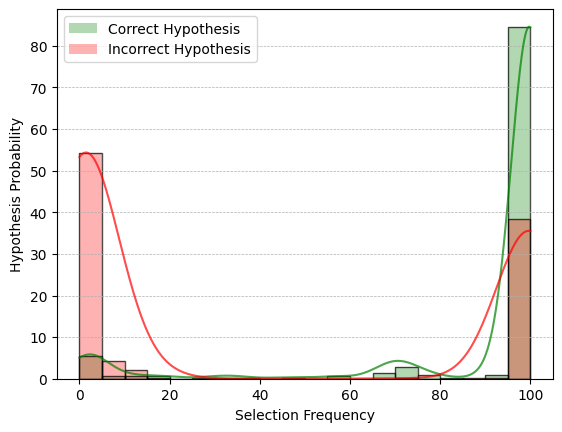

In [29]:
#partial at 25%
use_info = "use hypothesis"
num_epochs = 100

DO = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, rand_state, device = "cpu")
DO, TVM, model = full_experiment(use_info, DO, INSPECT, batch_size, hidden_size, output_size, num_epochs, rand_state, 
                                 results_path, dropout = 0.05, nu = 0.1, normalize_grads_contx = False, use_context = True, final_analysis = False)

print(INSPECT.calculate_val_acc(DO, TVM, model, data = "validation"))
print(INSPECT.calculate_val_acc(DO, TVM, model, data = "test"))

print(INSPECT.calculate_val_auc(DO, TVM, model, data = "validation"))
print(INSPECT.calculate_val_auc(DO, TVM, model, data = "test"))

selection_histograms(DO, TVM, num_epochs, rand_state, partial_perc)

100%|██████████| 100/100 [07:18<00:00,  4.38s/it]


0.5921052631578947
0.7068965517241379
0.5508960573476703
0.6513629842180775


findfont: Font family ['Cambria'] not found. Falling back to DejaVu Sans.


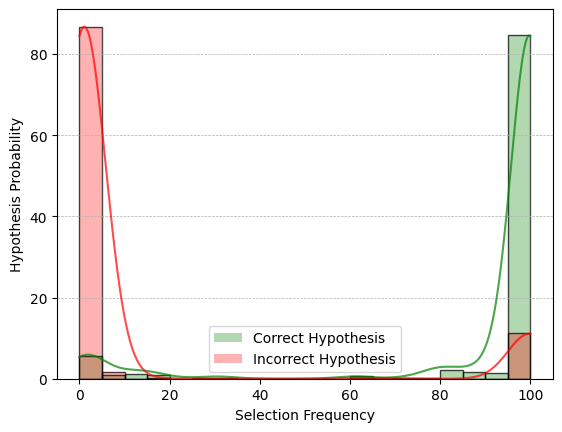

In [3]:
#partial at 80%
use_info = "use hypothesis"
num_epochs = 100

DO = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, rand_state, device = "cpu")
DO, TVM, model = full_experiment(use_info, DO, INSPECT, batch_size, hidden_size, output_size, num_epochs, rand_state, 
                                 results_path, dropout = 0.05, nu = 0.1, normalize_grads_contx = False, use_context = True, final_analysis = False)

print(INSPECT.calculate_val_acc(DO, TVM, model, data = "validation"))
print(INSPECT.calculate_val_acc(DO, TVM, model, data = "test"))

print(INSPECT.calculate_val_auc(DO, TVM, model, data = "validation"))
print(INSPECT.calculate_val_auc(DO, TVM, model, data = "test"))

selection_histograms(DO, TVM, num_epochs, rand_state, partial_perc)

100%|██████████| 500/500 [35:49<00:00,  4.30s/it]


0.5921052631578947
0.5862068965517241
0.7369175627240143
0.7732843137254902


LinAlgError: singular matrix

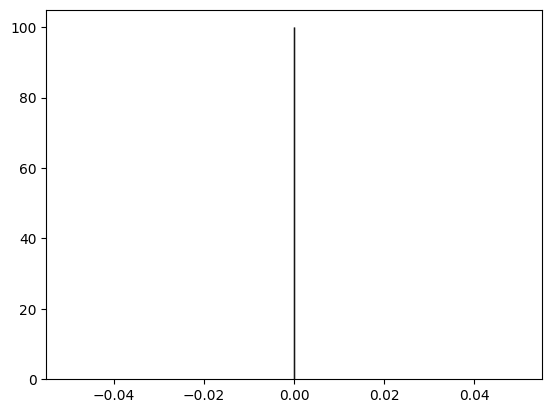

In [11]:
use_info = "use hypothesis"
num_epochs = 500

rand_state = 0
set_to_deterministic(rand_state)
DO = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, rand_state, device = "cpu")
DO, TVM, model = full_experiment(use_info, DO, INSPECT, batch_size, hidden_size, output_size, num_epochs, rand_state, 
                                 results_path, dropout = 0.05, nu = 0.1, normalize_grads_contx = False, use_context = True, final_analysis = False)

print(INSPECT.calculate_val_acc(DO, TVM, model, data = "validation"))
print(INSPECT.calculate_val_acc(DO, TVM, model, data = "test"))

print(INSPECT.calculate_val_auc(DO, TVM, model, data = "validation"))
print(INSPECT.calculate_val_auc(DO, TVM, model, data = "test"))

selection_histograms(DO, TVM, num_epochs, rand_state, partial_perc)

In [5]:
#DO.val_outcomes_tensor[:10]

#for batch_i, (inputs, labels) in enumerate(TVM.dataloader):
#    print(labels[:10])
#    break

#model(DO.full_val_input_tensor)[:10]

In [3]:
#Number of loops to ensure statistical significance
num_loops = 15
num_epochs = 200
r_state = 0
use_info = "full info"
hyperparameters = {"lr": {"value": 0.004}, "dropout": {"value": 0.05}, "nu": {"value": 0.1}}

DO = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, r_state, device = "cpu")
if not DO.lack_partial_coverage:
    print("Executing...")
    DO, TVM, model = full_experiment(use_info, DO, INSPECT, batch_size, hidden_size, output_size, num_epochs, r_state, results_path,
                     hyperparameters["dropout"]["value"], hyperparameters["lr"]["value"], hyperparameters["nu"]["value"], False)

Executing...


In [6]:
def model_predict(TVM, model, tensors):
    model.eval()
    val_pred = model(tensors)
    val_pred = val_pred.detach().numpy()
    return val_pred

print(np.mean(DO.df_val[DO.target_vars].values))

val_tensors = DO.full_val_input_tensor # Inspector._get_val_tensors(DO, TVM, "validation")
val_pred = model_predict(TVM, model, val_tensors)
print(np.mean(val_pred))

print(INSPECT.calculate_val_r2score(DO, TVM, model, data = "validation"))
print(INSPECT.calculate_val_r2score(DO, TVM, model, data = "test"))

print(INSPECT.calculate_val_acc(DO, TVM, model, data = "validation"))
print(INSPECT.calculate_val_acc(DO, TVM, model, data = "test"))

print(INSPECT.calculate_val_auc(DO, TVM, model, data = "validation"))
print(INSPECT.calculate_val_auc(DO, TVM, model, data = "test"))

0.40789473684210525
0.36164415
0.2618032813927744
0.2693884431985144
0.7763157894736842
0.7241379310344828
0.810752688172043
0.8321078431372549


In [129]:
#Number of loops to ensure statistical significance
num_loops = 10
num_epochs = 2
partial_perc = 0.1

hyperparameters = {"lr": {"value": 0.004}, "dropout": {"value": 0.05}, "nu": {"value": 0.1},
                   "normalize_grads_contx": {"value":False}, "use_context": {"value":True}}


inpt_vars = ['Time'] #, "Frequency"] #
target_vars = ['Donate_Blood']
miss_vars = ['Recency']
hypothesis = [[2, 4, 10, 16, 21]] #Recency

In [130]:
#%%capture

#num of epochs in use hypothesis is increased
multi_experiments(num_loops, "use hypothesis", int(num_epochs*2.5), data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, 
                  INSPECT, batch_size, hidden_size, output_size, results_path, hyperparameters)
multi_experiments(num_loops, "partial info",   int(num_epochs*2.5), data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, 
                  INSPECT, batch_size, hidden_size, output_size, results_path, hyperparameters)
multi_experiments(num_loops, "use known only", int(num_epochs*2.5), data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc,
                  INSPECT, batch_size, hidden_size, output_size, results_path, hyperparameters)
multi_experiments(num_loops, "full info",      int(num_epochs*2.5), data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc,
                  INSPECT, batch_size, hidden_size, output_size, results_path, hyperparameters)

Deleted 5 files in: ../saved_results/Donated Blood/use hypothesis/final_analysis



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:03<00:14,  3.63s/it]

 40%|████      | 2/5 [00:07<00:11,  3.79s/it]

 60%|██████    | 3/5 [00:10<00:07,  3.52s/it]

 80%|████████  | 4/5 [00:13<00:03,  3.40s/it]

100%|██████████| 5/5 [00:17<00:00,  3.42s/it]

 10%|█         | 1/10 [00:17<02:34, 17.15s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:02<00:11,  2.98s/it]

 40%|████      | 2/5 [00:05<00:09,  3.00s/it]

 60%|██████    | 3/5 [00:09<00:06,  3.11s/it]

 80%|████████  | 4/5 [00:12<00:03,  3.11s/it]

100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

 20%|██        | 2/10 [00:32<02:09, 16.18s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:03<00:12,  3.12s/it]

 40%|████      | 2/5 [00:06<00:09,  3.08s/it]

 60%|██████    | 3/5 [00:09<00:06,  3.16s/it]

 80%|████████  | 4/5 [00:12<00:03,  3.10s/it]

100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

 30%|███       | 3/10 [00:48<01:51, 15.87

Deleted 2 files in: ../saved_results/Donated Blood/partial info/final_analysis



100%|██████████| 10/10 [00:00<00:00, 13.50it/s]


Deleted 2 files in: ../saved_results/Donated Blood/use known only/final_analysis



100%|██████████| 10/10 [00:00<00:00, 15.47it/s]


Deleted 2 files in: ../saved_results/Donated Blood/full info/final_analysis



100%|██████████| 10/10 [00:00<00:00, 15.38it/s]


In [131]:
#partial_perc = 0.1
#real epochs = 5
#loop 1
#inpt_vars = ['Time'] #Frequency
#target_vars = ['Donate_Blood']
#miss_vars = ['Recency']
#hypothesis = [[2, 4, 10, 16, 21]] #Recency

df, df_notavg = INSPECT.create_test_comparison_table(data_path, inpt_vars, target_vars, miss_vars, hypothesis, 
                                                     partial_perc, batch_size, best_imput = "", task_type = "classification") #
df_notavg

,Method,rand_states,avg_acc_score,avg_auc
0,use hypothesis,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[0.5862068965517241, 0.6206896551724138, 0.637...","[0.34620098039215685, 0.5505050505050504, 0.73..."
1,full info,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[0.5862068965517241, 0.6206896551724138, 0.637...","[0.5618872549019608, 0.5732323232323232, 0.734..."
2,partial info,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[0.5862068965517241, 0.6206896551724138, 0.637...","[0.31066176470588236, 0.5681818181818182, 0.73..."
3,use known only,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[0.5862068965517241, 0.6206896551724138, 0.637...","[0.440563725490196, 0.5555555555555556, 0.2824..."


In [117]:
#partial_perc = 0.1
#real epochs = 50
#loop 1
#inpt_vars = ['Time'] #Frequency
#target_vars = ['Donate_Blood']
#miss_vars = ['Recency']
#hypothesis = [[2, 4, 10, 16, 21]] #Recency

df, df_notavg = INSPECT.create_test_comparison_table(data_path, inpt_vars, target_vars, miss_vars, hypothesis, 
                                                     partial_perc, batch_size, best_imput = "", task_type = "classification") #
df_notavg

,Method,rand_states,avg_acc_score,avg_auc
0,use hypothesis,[0],[0.5862068965517241],[0.3155637254901961]
1,full info,[0],[0.5862068965517241],[0.7714460784313726]
2,partial info,[0],[0.5862068965517241],[0.32169117647058826]
3,use known only,[0],[0.5862068965517241],[0.440563725490196]


In [112]:
#partial_perc = 0.1
#real epochs = 500
#inpt_vars = ['Time'] #Frequency
#target_vars = ['Donate_Blood']
#miss_vars = ['Recency']
#hypothesis = [[2, 4, 10, 16, 21]] #Recency

df, df_notavg = INSPECT.create_test_comparison_table(data_path, inpt_vars, target_vars, miss_vars, hypothesis, 
                                                     partial_perc, batch_size, best_imput = "", task_type = "classification") #
df

,Method,avg_acc_score,std_acc_score,avg_auc,std_auc
0,full info,0.651724,0.068156,0.719364,0.077854
1,partial info,0.625287,0.068234,0.635800,0.093611
2,use known only,0.626437,0.046120,0.532072,0.086291


In [111]:
df_notavg["rand_states"].iloc[0]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15]

In [42]:
#partial_perc = 0.5
#inpt_vars = ['Time']
#target_vars = ['Donate_Blood']
#miss_vars = ['Recency']
#hypothesis = [[2, 11, 19, 80]]
df, df_notavg = INSPECT.create_test_comparison_table(data_path, inpt_vars, target_vars, miss_vars, hypothesis, 
                                                     partial_perc, batch_size, best_imput = "", task_type = "classification") #
df

,Method,avg_acc_score,std_acc_score,avg_auc,std_auc
0,full info,0.645977,0.060995,0.708568,0.073775
1,partial info,0.652874,0.062281,0.699169,0.077681
2,use known only,0.620690,0.045399,0.527946,0.084308


In [43]:
df_notavg["rand_states"].iloc[0]

[0, 2, 3, 4, 5, 7, 9, 10, 11, 15, 17, 18, 19, 20, 21]

In [25]:
#partial_perc = 0.85
#inpt_vars = ['Time', ]
#target_vars = ['Donate_Blood']
#miss_vars = ['Recency']
#hypothesis = [[2, 11, 19, 80]]
df, df_notavg = INSPECT.create_test_comparison_table(data_path, inpt_vars, target_vars, miss_vars, hypothesis, 
                                                     partial_perc, batch_size, best_imput = "", task_type = "classification") #
df

,Method,avg_acc_score,std_acc_score,avg_auc,std_auc
0,full info,0.704598,0.046633,0.753674,0.076053
1,partial info,0.703448,0.057425,0.756390,0.072587
2,use known only,0.687356,0.046206,0.722381,0.078024


In [26]:
df_notavg["rand_states"].iloc[0]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [21]:
#partial_perc = 0.95
#inpt_vars = ['Time', 'Frequency']
#target_vars = ['Donate_Blood']
#miss_vars = ['Recency']
#hypothesis = [[2, 11, 19, 80]]
df, df_notavg = INSPECT.create_test_comparison_table(data_path, inpt_vars, target_vars, miss_vars, hypothesis, 
                                                     partial_perc, batch_size, best_imput = "", task_type = "classification") #
df

,Method,avg_acc_score,std_acc_score,avg_auc,std_auc
0,full info,0.704598,0.046633,0.753674,0.076053
1,partial info,0.702299,0.055768,0.756709,0.074647
2,use known only,0.687356,0.046206,0.722381,0.078024


In [22]:
df_notavg["rand_states"].iloc[0]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [17]:
#partial_perc = 0.5
#inpt_vars = ['Time', 'Frequency']
#target_vars = ['Donate_Blood']
#miss_vars = ['Recency']
#hypothesis = [[2, 11, 19, 80]]
df, df_notavg = INSPECT.create_test_comparison_table(data_path, inpt_vars, target_vars, miss_vars, hypothesis, 
                                                     partial_perc, batch_size, best_imput = "", task_type = "classification") #
df

,Method,avg_acc_score,std_acc_score,avg_auc,std_auc
0,full info,0.708046,0.046463,0.748082,0.070978
1,partial info,0.686207,0.051992,0.739694,0.070947
2,use known only,0.685057,0.056122,0.705475,0.082564


In [18]:
df_notavg["rand_states"].iloc[0]

[0, 2, 3, 4, 5, 7, 9, 10, 11, 15, 17, 18, 19, 20, 21]

In [6]:
#partial_perc = 0.5
#inpt_vars = ['Time', 'Frequency']
#target_vars = ['Donate_Blood']
#miss_vars = ['Recency']
df, df_notavg = INSPECT.create_test_comparison_table(data_path, inpt_vars, target_vars, miss_vars, hypothesis, 
                                                     partial_perc, batch_size, best_imput = "", task_type = "classification") #
df

,Method,avg_acc_score,std_acc_score,avg_auc,std_auc
0,full info,0.712644,0.055483,0.758485,0.074390
1,partial info,0.696552,0.054449,0.745413,0.103576
2,use known only,0.645977,0.058677,0.712888,0.079505


In [15]:
#partial_perc = 0.5
#inpt_vars = ['Time', 'Frequency']
#target_vars = ['Donate_Blood']
#miss_vars = ['Recency']
df, df_notavg = INSPECT.create_test_comparison_table(data_path, inpt_vars, target_vars, miss_vars, hypothesis, 
                                                     partial_perc, batch_size, best_imput = "", task_type = "classification") #
df

,Method,avg_acc_score,std_acc_score,avg_auc,std_auc
0,full info,0.708046,0.046463,0.748082,0.070978
1,partial info,0.686207,0.051992,0.739694,0.070947
2,use known only,0.685057,0.056122,0.705475,0.082564


In [14]:
df_notavg["rand_states"].iloc[0]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [9]:
#partial_perc = 0.9
#inpt_vars = ['Time', 'Frequency']
#target_vars = ['Donate_Blood']
#miss_vars = ['Recency']
df, df_notavg = INSPECT.create_test_comparison_table(data_path, inpt_vars, target_vars, miss_vars, hypothesis, 
                                                     partial_perc, batch_size, best_imput = "", task_type = "classification") #
df

,Method,avg_acc_score,std_acc_score,avg_auc,std_auc
0,full info,0.704598,0.046633,0.753674,0.076053
1,partial info,0.711494,0.055053,0.752558,0.070690
2,use known only,0.687356,0.046206,0.722381,0.078024


In [11]:
df_notavg["rand_states"].iloc[0]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [12]:
#partial_perc = 0.85
#inpt_vars = ['Time', 'Frequency']
#target_vars = ['Donate_Blood']
#miss_vars = ['Recency']
df, df_notavg = INSPECT.create_test_comparison_table(data_path, inpt_vars, target_vars, miss_vars, hypothesis, 
                                                     partial_perc, batch_size, best_imput = "", task_type = "classification") #
df

,Method,avg_acc_score,std_acc_score,avg_auc,std_auc
0,full info,0.705517,0.050425,0.748759,0.071579
1,partial info,0.695172,0.052232,0.741602,0.070185
2,use known only,0.686897,0.046947,0.722981,0.072491


In [13]:
df_notavg

,Method,rand_states,avg_acc_score,avg_auc
0,full info,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.7241379310344828, 0.7413793103448276, 0.706...","[0.8247549019607844, 0.8377525252525252, 0.756..."
1,partial info,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.7068965517241379, 0.7586206896551724, 0.689...","[0.8333333333333333, 0.8339646464646464, 0.764..."
2,use known only,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.7068965517241379, 0.7413793103448276, 0.672...","[0.8186274509803922, 0.8750000000000001, 0.735..."


In [15]:
#partial_perc = 0.5
#inpt_vars = ['Time', 'Frequency']
#target_vars = ['Donate_Blood']
#miss_vars = ['Recency']
df, df_notavg = INSPECT.create_test_comparison_table(data_path, inpt_vars, target_vars, miss_vars, hypothesis, 
                                                     partial_perc, batch_size, best_imput = "", task_type = "classification") #
df

,Method,avg_acc_score,std_acc_score,avg_auc,std_auc
0,full info,0.705517,0.050425,0.748759,0.071579
1,partial info,0.695172,0.052232,0.741602,0.070185
2,use known only,0.686897,0.046947,0.722981,0.072491


In [16]:
df_notavg

,Method,rand_states,avg_acc_score,avg_auc
0,full info,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.7241379310344828, 0.7413793103448276, 0.706...","[0.8247549019607844, 0.8377525252525252, 0.756..."
1,partial info,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.7068965517241379, 0.7586206896551724, 0.689...","[0.8333333333333333, 0.8339646464646464, 0.764..."
2,use known only,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.7068965517241379, 0.7413793103448276, 0.672...","[0.8186274509803922, 0.8750000000000001, 0.735..."


In [6]:
#partial_perc = 0.3
#inpt_vars = ['Time', 'Frequency']
#target_vars = ['Donate_Blood']
#miss_vars = ['Recency']
df, df_notavg = INSPECT.create_test_comparison_table(data_path, inpt_vars, target_vars, miss_vars, hypothesis, 
                                                     partial_perc, batch_size, best_imput = "", task_type = "classification") #
df

,Method,avg_acc_score,std_acc_score,avg_auc,std_auc
0,full info,0.626437,0.114222,0.614533,0.171021
1,partial info,0.616379,0.102032,0.604921,0.170998
2,use known only,0.652299,0.059864,0.640294,0.122628


In [3]:
df, df_notavg = INSPECT.create_test_comparison_table(data_path, inpt_vars, target_vars, miss_vars, hypothesis, 
                                                     partial_perc, batch_size, best_imput = "", task_type = "classification") #
#df[["Method","avg_r2_score","avg_mse","avg_mae"]]
df

,Method,avg_acc_score,std_acc_score,avg_auc,std_auc
0,use hypothesis,0.563218,0.106407,0.520249,0.122155
1,full info,0.712644,0.055483,0.758485,0.074390
2,partial info,0.685057,0.048549,0.717648,0.080329
3,use known only,0.645977,0.058677,0.712888,0.079505


In [4]:
df_notavg

,Method,rand_states,avg_acc_score,avg_auc
0,use hypothesis,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.5862068965517241, 0.3793103448275862, 0.637...","[0.5269607843137255, 0.7708333333333333, 0.303..."
1,full info,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.7413793103448276, 0.7413793103448276, 0.706...","[0.8468137254901961, 0.8478535353535354, 0.754..."
2,partial info,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.7758620689655172, 0.6206896551724138, 0.672...","[0.8161764705882353, 0.7279040404040404, 0.774..."
3,use known only,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.7068965517241379, 0.7241379310344828, 0.655...","[0.8069852941176471, 0.8295454545454546, 0.683..."


In [6]:
#len(df_notavg[df_notavg["Method"]=="use hypothesis"]["avg_auc"].values[0])

In [7]:
#df_notavg[df_notavg["Method"]=="use hypothesis"]["avg_auc"].values[0]

In [4]:
df, df_notavg = INSPECT.create_test_comparison_table(data_path, inpt_vars, target_vars, miss_vars, hypothesis, 
                                                     partial_perc, batch_size, best_imput = "", task_type = "classification") #
#df[["Method","avg_r2_score","avg_mse","avg_mae"]]
df

,Method,avg_acc_score,std_acc_score,avg_auc,std_auc
0,use hypothesis,0.563218,0.106407,0.506430,0.121207
1,full info,0.712644,0.055483,0.758485,0.074390
2,partial info,0.685057,0.048549,0.717648,0.080329
3,use known only,0.645977,0.058677,0.712888,0.079505


In [5]:
%%capture

for imput_method in ["Iterative MICE Imputer", "KNN Imputer", "Miss Forest", "Deep Regressor", "Soft Impute", 
                     "Matrix Factorization", "Hyperimpute", "TabPFN"]: #, "Midas"
    counter = 0
    use_info = "use imputation" 
    num_epochs = 400
    for r_state in range(300):
        DO = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, r_state, device = "cpu")
        if not DO.lack_partial_coverage:
            counter += 1
            AM = AlgoModulators(DO, lr = 0.004)
            IMP = Imputer(DO)
            dataloader = IMP.impute_w_sel(DO, imput_method, batch_size)

            model = initialize_model(DO, dataloader, hidden_size, r_state, dropout = 0.05) 
            TVM = TrainValidationManager(use_info, num_epochs, dataloader, batch_size, r_state, results_path,
                                        imput_method = imput_method, final_analysis = True)
            TVM.train_model(DO, AM, model, final_analysis = True)
            INSPECT.save_train_val_logs(DO, AM, TVM, model, imput_method, final_analysis = True)
        if counter == 15:
            break
            

In [6]:
#partial 8%
INSPECT.create_comparison_table(final_analysis = True, use_info= "use imputation")

,Method,valid_min_errors_mean,valid_min_errors_std
0,Deep Regressor,0.021994,0.006158
1,Hyperimpute,0.014798,0.003372
2,Iterative MICE Imputer,0.017025,0.002185
3,KNN Imputer,0.015783,0.002854
4,Matrix Factorization,0.028538,0.002555
5,Miss Forest,0.013798,0.003545
6,Soft Impute,0.028846,0.002594
7,TabPFN,0.010166,0.002840


In [7]:
#partial 8%
df, df_notavg = INSPECT.create_test_comparison_table(data_path, inpt_vars, target_vars, miss_vars, hypothesis, 
                                                     partial_perc, batch_size, best_imput = "TabPFN") #
df[["Method","avg_r2_score","avg_mse","avg_mae"]]

,Method,avg_r2_score,avg_mse,avg_mae
0,full info,0.828043,0.005827,0.056247
1,partial info,0.528283,0.015641,0.095204
2,use hypothesis,0.742764,0.008592,0.071962
3,use imputation,0.737578,0.008739,0.068960
4,use known only,0.623568,0.012632,0.088167
